In [1]:
from typing import NamedTuple
import pandas as pd
from pathlib import Path
import cudf
import cugraph
import matplotlib.pyplot as plt
import networkx as nx


class CollegeMessage(NamedTuple):
    source: int  # source id
    target: int  # target id
    unix_timestamp: int  # seconds after last epoch

def read_message_data(datapath: str) -> cudf.DataFrame:
    filepath = Path.cwd() / Path(datapath)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(datapath)}"
        )

    print(f"Using file: {filepath.absolute()}")

    df = cudf.read_csv(filepath, sep=' ', names=['source', 'target', 'unix_timestamp'], dtype=['int32', 'int32', 'int32'])
    print("done")
    return df

def remove_low_degree_nodes(data: cudf.DataFrame, min_degree: int) -> cudf.DataFrame:
    in_degree = data['target'].value_counts()
    out_degree = data['source'].value_counts()
    high_degree_nodes = set(in_degree[in_degree >= min_degree].index.to_pandas()) & set(out_degree[out_degree >= min_degree].index.to_pandas())
    return data[data['source'].isin(high_degree_nodes) & data['target'].isin(high_degree_nodes)]

def create_graph(data: cudf.DataFrame) -> cugraph.DiGraph:
    graph = cugraph.DiGraph()
    graph.from_cudf_edgelist(data, source='source', destination='target', edge_attr='unix_timestamp')
    return graph

def graph_figure(graph: cugraph.DiGraph) -> plt.Figure:
    figure = plt.figure(figsize=(10, 10))
    pos = cugraph.force_atlas2(graph)
    nx_graph = graph.to_networkx()
    nx.draw(nx_graph, pos, with_labels=False, node_size=10)
    return figure

In [2]:
_DATA_PATH = "./dataset/CollegeMsg.txt"

_MESSAGES = read_message_data(_DATA_PATH)
DF_MESSAGES = remove_low_degree_nodes(pd.DataFrame(_MESSAGES), 2)
GRAPH_MESSAGES = create_graph(DF_MESSAGES)

Using file: /home/mojmir-majer/projects/private/github/rug-sna-pizza-giving/college_msg_files/dataset/CollegeMsg.txt
done


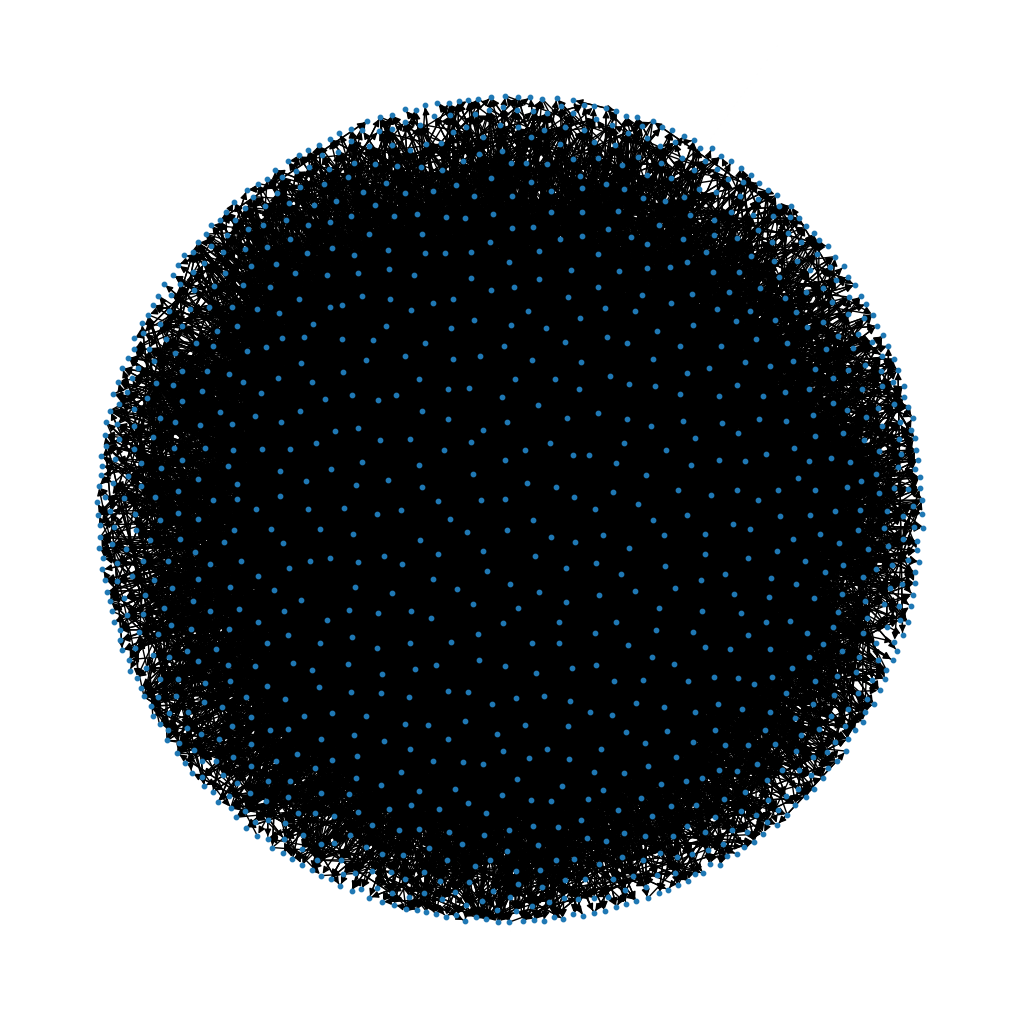

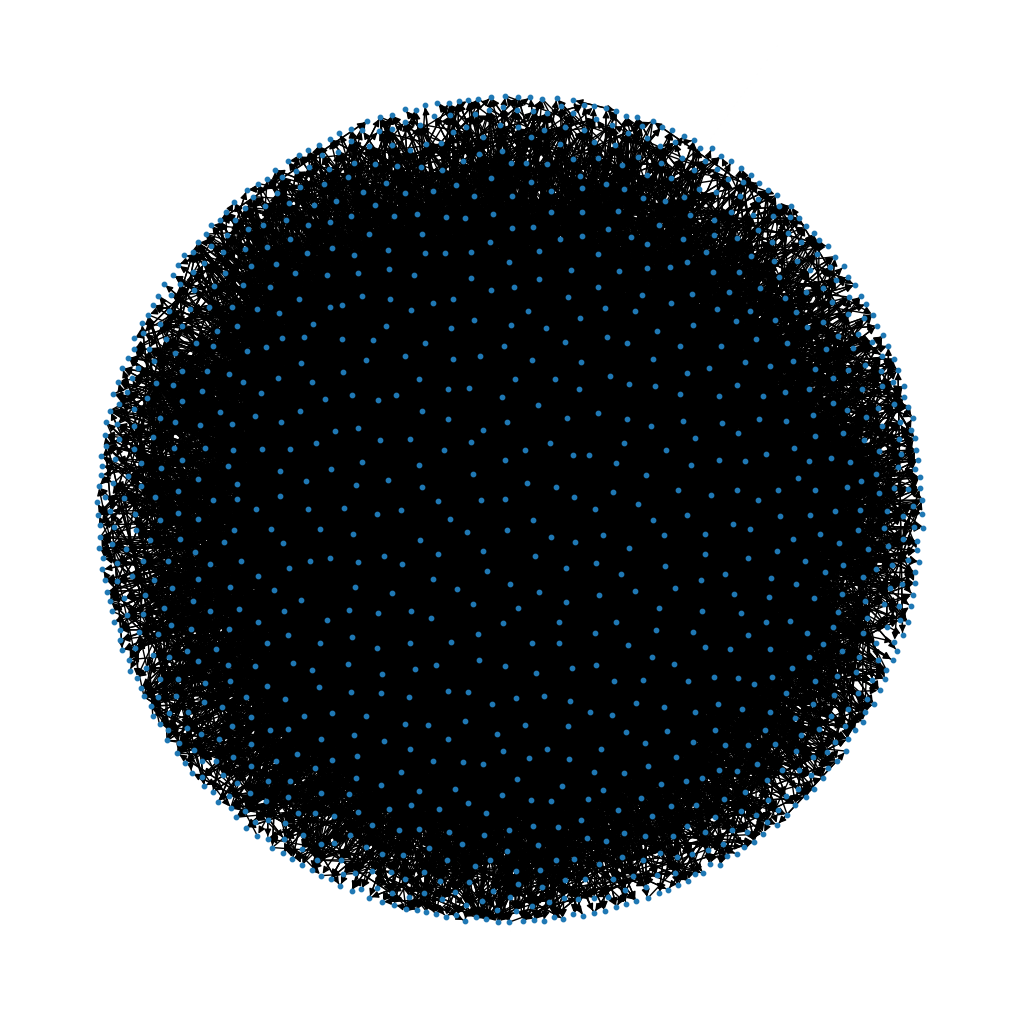

In [3]:
graph_figure(GRAPH_MESSAGES)